In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
from torchvision import datasets
from tqdm import tqdm
import sys

Встановлення сіду генератору

In [19]:
torch.manual_seed(10)

Завантаження датасету OxfordIIITPet

In [20]:
training_data = datasets.OxfordIIITPet(
    root="datasets",
    download=True,
)

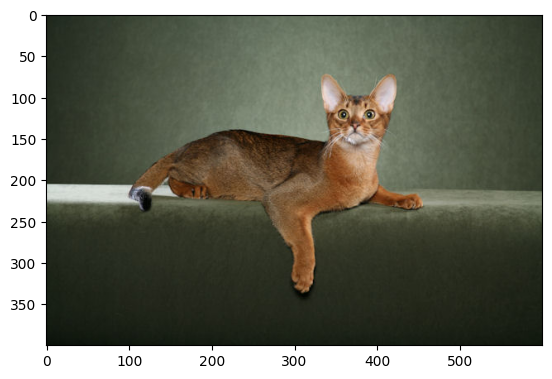

In [21]:
plt.imshow(plt.imread('./datasets/oxford-iiit-pet/images/Abyssinian_1.jpg'))

In [22]:
filenames = glob('./datasets/oxford-iiit-pet/images/*.jpg')

In [23]:
# for file in filenames:
#     try:
#         img = plt.imread(file)
#         Image.fromarray(img).convert('RGB')
#     except Exception as e:
#         filenames.remove(file)

In [24]:
class PetDataSet(Dataset):

    def __init__(self, filenames, class_to_label, transforms=None):
        self.filenames = filenames
        self.transforms = transforms
        self.class_to_label = class_to_label

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        filename = self.filenames[i]
        # img = plt.imread(filename)
        # img = Image.fromarray(img).convert('RGB')
        img = Image.open(filename).convert('RGB')
        img = np.array(img).astype(np.uint8)

        if self.transforms is not None:
            img = self.transforms(img)
        label = self.get_label_from_filename(filename)
        return img ,label

    def get_label_from_filename(self, filename):
        clazz =  filename.rsplit('\\', 1)[1].rsplit('_', 1)[0].replace('_', ' ').title()
        return self.class_to_label[clazz]

In [25]:
vgg_format = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [26]:
dataset=PetDataSet(filenames,training_data.class_to_idx,vgg_format)

train_ds_length = int(0.6 * len(dataset))
val_ds_length = int(0.2 * len(dataset))
test_ds_length = int(0.2 * len(dataset))

train_ds,val_ds, test_ds = torch.utils.data.random_split(dataset, [train_ds_length,val_ds_length, test_ds_length])

train_dl = DataLoader(train_ds, batch_size=16)
val_dl = DataLoader(val_ds, batch_size=16)
test_dl = DataLoader(test_ds, batch_size=16)

Модель

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
load_from_existing = False

In [29]:
model = torchvision.models.vgg19(pretrained=True)

number_of_labels = len(training_data.classes)
model.classifier = torch.nn.Sequential(
    model.classifier,
    torch.nn.Linear(in_features=1000, out_features= number_of_labels, bias=True)
)
if load_from_existing:
    model.load_state_dict(torch.load('best_vgg.mdl'))
    print('loaded from previous save !!!')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Навчання моделі

In [30]:
cross_el = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
epochs = 50

In [31]:
def evalute(model, loader):
    model.eval()

    correct = 0
    total = len(loader.dataset)
    val_bar = tqdm(loader, file=sys.stdout)
    for x, y in val_bar:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
        correct += torch.eq(pred, y).sum().float().item()


    return correct / total

In [32]:
best_acc, best_epoch = 0, 0
losses = []
accuracy = []
for epoch in range(epochs):
    epoch_losses=[]
    model.train()
    train_bar = tqdm(train_dl, file=sys.stdout)
    for data in train_bar:
        x, y = data
        output = model(x.to(device))
        loss = cross_el(output, y.to(device))
        epoch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss)
    losses.append(np.mean(epoch_losses))
    if epoch % 1 == 0:  # You can change the validation frequency as you wish

        val_acc = evalute(model, val_dl)
        accuracy.append(val_acc)
        print('val_acc = ', val_acc)
        if val_acc > best_acc:
            best_epoch = epoch
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_vgg.mdl')

100%|██████████| 93/93 [00:18<00:00,  5.13it/s]
val_acc =  0.8261163734776725
100%|██████████| 93/93 [00:18<00:00,  5.14it/s]
val_acc =  0.8531799729364006
100%|██████████| 93/93 [00:18<00:00,  4.98it/s]
val_acc =  0.8653585926928281
100%|██████████| 93/93 [00:18<00:00,  5.15it/s]
val_acc =  0.8694181326116374
100%|██████████| 93/93 [00:17<00:00,  5.18it/s]
val_acc =  0.8525033829499323
100%|██████████| 93/93 [00:18<00:00,  5.15it/s]
val_acc =  0.8694181326116374
100%|██████████| 93/93 [00:17<00:00,  5.18it/s]
val_acc =  0.881596752368065
100%|██████████| 93/93 [00:18<00:00,  5.16it/s]
val_acc =  0.8809201623815968
100%|██████████| 93/93 [00:17<00:00,  5.17it/s]
val_acc =  0.8843031123139378
100%|██████████| 93/93 [00:18<00:00,  5.14it/s]
val_acc =  0.8741542625169147
100%|██████████| 93/93 [00:18<00:00,  5.14it/s]
val_acc =  0.8775372124492558
100%|██████████| 93/93 [00:18<00:00,  5.14it/s]
val_acc =  0.8721244925575101
100%|██████████| 93/93 [00:18<00:00,  5.15it/s]
val_acc =  0.8951

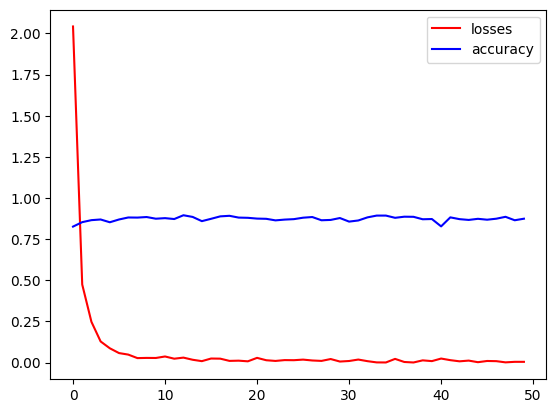

In [33]:
plt.plot(losses, label='losses',color='red')
plt.plot(accuracy, label= 'accuracy', color='blue')
plt.legend()
plt.show()

In [34]:
model.load_state_dict(torch.load('best_vgg.mdl'))
print('loaded from ckpt!')

test_acc = evalute(model, test_dl)
print('test acc:', test_acc)

loaded from ckpt!
100%|██████████| 93/93 [00:18<00:00,  5.06it/s]
test acc: 0.8849797023004059
